# 2. A simple denoising model on MNIST

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (08/04/2023)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.6.2)
- Torch (tested on v1.12.1)

### Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# CUDA check
CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
print(torch.cuda.is_available())
print(device)

False
cpu


### MNIST Dataset

In [3]:
# Load the MNIST dataset
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

In [4]:
# Test the model on a single image
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

### Model

Fully connected and hidden layer size can be chosen.

In [5]:
# Define the encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

In [6]:
# Define the decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [7]:
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

### Training a denoising model

In [8]:
# Hyperparameters
epochs = 10
learning_rate = 1e-3
noise_factor = 0.5

In [9]:
# Initialize the model, loss function, and optimizer
model = Denoiser()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
# Training loop
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        # Noise the data with one or many steps of SDEs
        # (Here a single step Brownian Motion)
        data = data.view(data.size(0), -1)
        noisy_data = data + noise_factor*torch.randn_like(data)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(noisy_data)
        
        # Backprop
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        
        # Display
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{epochs}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')

Epoch: 1/10, Batch: 0/938, Loss: 1.2449253797531128
Epoch: 1/10, Batch: 100/938, Loss: 0.8187461495399475
Epoch: 1/10, Batch: 200/938, Loss: 0.6412491202354431
Epoch: 1/10, Batch: 300/938, Loss: 0.6011403799057007
Epoch: 1/10, Batch: 400/938, Loss: 0.5702775716781616
Epoch: 1/10, Batch: 500/938, Loss: 0.587981641292572
Epoch: 1/10, Batch: 600/938, Loss: 0.5702048540115356
Epoch: 1/10, Batch: 700/938, Loss: 0.5356922745704651
Epoch: 1/10, Batch: 800/938, Loss: 0.5518530011177063
Epoch: 1/10, Batch: 900/938, Loss: 0.5340136289596558
Epoch: 2/10, Batch: 0/938, Loss: 0.5196548700332642
Epoch: 2/10, Batch: 100/938, Loss: 0.5188783407211304
Epoch: 2/10, Batch: 200/938, Loss: 0.525750458240509
Epoch: 2/10, Batch: 300/938, Loss: 0.529144287109375
Epoch: 2/10, Batch: 400/938, Loss: 0.5462660789489746
Epoch: 2/10, Batch: 500/938, Loss: 0.5253822207450867
Epoch: 2/10, Batch: 600/938, Loss: 0.5035701394081116
Epoch: 2/10, Batch: 700/938, Loss: 0.4945460855960846
Epoch: 2/10, Batch: 800/938, Loss: 

### Testing denoising model on noised MNIST images

In [75]:
# Preparing some test samples
count = 10
for batch_idx, (test_data, _) in enumerate(test_loader):
    if(batch_idx == count):
        test_data = test_data.view(test_data.size(0), -1)
        noisy_test_data = test_data + noise_factor*torch.randn_like(test_data)
        output = model(noisy_test_data)
        break

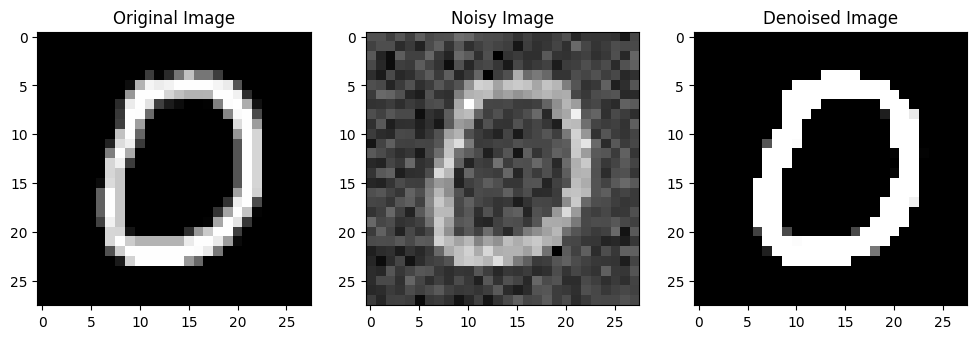

In [76]:
# Plot the original image, noisy image, and the denoised image
fig, axes = plt.subplots(1, 3, figsize = (12, 4))
axes[0].imshow(test_data.view(28, 28).detach().numpy(), cmap = 'gray')
axes[0].set_title('Original Image')
axes[1].imshow(noisy_test_data.view(28, 28).detach().numpy(), cmap = 'gray')
axes[1].set_title('Noisy Image')
axes[2].imshow(output.view(28, 28).detach().numpy(), cmap = 'gray')
axes[2].set_title('Denoised Image')
plt.show()

### Testing model on pure noise?!

In [69]:
# Preparing some test samples
count = 7
for batch_idx, (test_data2, _) in enumerate(test_loader):
    if(batch_idx == count):
        test_data2 = test_data2.view(test_data2.size(0), -1)
        noisy_test_data2 = noise_factor*torch.randn_like(test_data2)
        output2 = model(noisy_test_data2)
        break

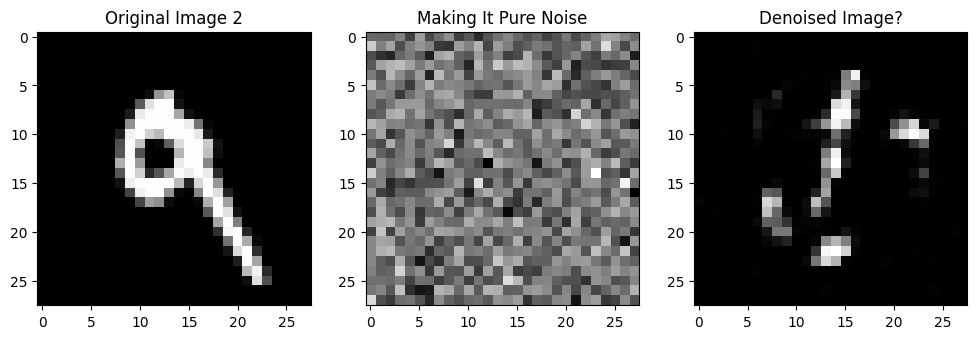

In [70]:
# Plot the original image, noisy image, and the denoised image
fig, axes = plt.subplots(1, 3, figsize = (12, 4))
axes[0].imshow(test_data2.view(28, 28).detach().numpy(), cmap = 'gray')
axes[0].set_title('Original Image 2')
axes[1].imshow(noisy_test_data2.view(28, 28).detach().numpy(), cmap = 'gray')
axes[1].set_title('Making It Pure Noise')
axes[2].imshow(output2.view(28, 28).detach().numpy(), cmap = 'gray')
axes[2].set_title('Denoised Image?')
plt.show()

In [61]:
# Preparing some test samples
count = 14
for batch_idx, (test_data3, _) in enumerate(test_loader):
    if(batch_idx == count):
        test_data3 = test_data3.view(test_data3.size(0), -1)
        noisy_test_data3 = noise_factor*torch.randn_like(test_data3)
        output2 = model(noisy_test_data3)
        output3 = model(output2)
        output4 = model(output3)
        output5 = model(output4)
        output6 = model(output5)
        break

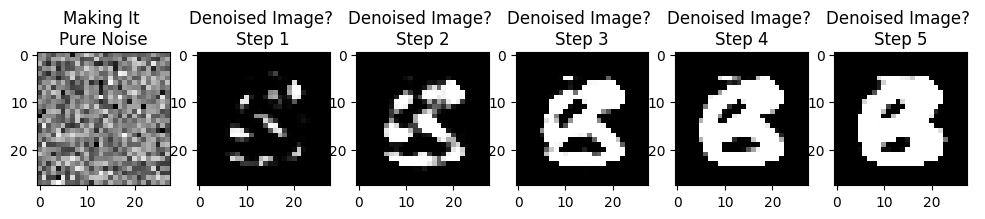

In [62]:
# Plot the original image, noisy image, and the denoised image
fig, axes = plt.subplots(1, 6, figsize = (12, 4))
axes[0].imshow(noisy_test_data3.view(28, 28).detach().numpy(), cmap = 'gray')
axes[0].set_title('Making It \nPure Noise')
axes[1].imshow(output2.view(28, 28).detach().numpy(), cmap = 'gray')
axes[1].set_title('Denoised Image? \nStep 1')
axes[2].imshow(output3.view(28, 28).detach().numpy(), cmap = 'gray')
axes[2].set_title('Denoised Image? \nStep 2')
axes[3].imshow(output4.view(28, 28).detach().numpy(), cmap = 'gray')
axes[3].set_title('Denoised Image? \nStep 3')
axes[4].imshow(output5.view(28, 28).detach().numpy(), cmap = 'gray')
axes[4].set_title('Denoised Image? \nStep 4')
axes[5].imshow(output6.view(28, 28).detach().numpy(), cmap = 'gray')
axes[5].set_title('Denoised Image? \nStep 5')
plt.show()